In [2]:
#Lets have matplotlib "inline"
%matplotlib inline
#%config InlineBackend.figure_format = 'retina'

import os
import sys

#Import packages we need
import numpy as np
from netCDF4 import Dataset

#Helpful during development
import importlib
#importlib.reload(module)


from matplotlib import animation, rc
from matplotlib import pyplot as plt

from IPython.display import clear_output

#Set large figure sizes
plt.rcParams["animation.html"] = "jshtml" #Javascript 
#plt.rcParams["animation.html"] = "html5" #mp4

plt.rc('text', usetex=False)
plt.rc('font', family='serif')

In [3]:
sys.path.insert(0, os.path.abspath(os.path.join(os.getcwd(), '../')))

from gpuocean.SWEsimulators import FBL, CTCS, KP07, CDKLM16
from gpuocean.utils import PlotHelper, Common, WindStress, IPythonMagic, OceanographicUtilities

In [4]:
%setup_logging -o bc_test.log
%cuda_context_handler gpu_ctx

Console logger using level INFO
File logger disabled
Python version 3.7.12 | packaged by conda-forge | (default, Oct 26 2021, 05:35:01) [MSC v.1916 64 bit (AMD64)]
Registering gpu_ctx in user workspace
PyCUDA version 2022.1
CUDA version (10, 2, 0)
Driver version 11070
Using 'Quadro P2000' GPU
Created context handle <2009220081104>


In [5]:
#Set this to false before committing to only get images
create_movie = False
movie_frames = None

# Misc helper functions

In [6]:
def printInfo(url):
    try:
        ncfile = Dataset(url)
        print("Variables")
        for var in ncfile.variables:
            print(var)

        print ("Attributes:")    
        for attr in ncfile.ncattrs():
            print(attr, ": ", ncfile.getncattr(attr))
    
    except Exception as e:
        raise e
        
    finally:
        ncfile.close()

In [7]:
def plotSolution(fig, 
                 eta, hu, hv, h, dx, dy, 
                 t, comment,
                 h_min=-1.5, h_max=1.5, 
                 uv_min=-0.05, uv_max=0.05, 
                 add_extra=False,
                 ax=None, sp=None):
    
    from datetime import timedelta
    fig.suptitle("Time = {:0>8} ({:s})".format(str(timedelta(seconds=int(t))), comment), 
                 fontsize=18,
                 horizontalalignment='left')
    
    ny, nx = eta.shape
    domain_extent = [0, nx*dx/1000, 0, ny*dy/1000]
    
    x_plots = 3
    y_plots = 1
    if (add_extra == True):
        x_plots=3
        y_plots=2
    
    V_max = 3 * (uv_max-uv_min) / np.max(h)
    R_min = -V_max/2000
    R_max = V_max/2000

    if (ax is None):
        ax = [None]*x_plots*y_plots
        sp = [None]*x_plots*y_plots
        
        ax[0] = plt.subplot(y_plots, x_plots, 1)
        sp[0] = ax[0].imshow(eta, interpolation="none", origin='lower', 
                             cmap=plt.cm.coolwarm, 
                             vmin=h_min, vmax=h_max, 
                             extent=domain_extent)
        plt.colorbar(sp[0], shrink=0.9)
        plt.axis('image')
        plt.title("eta")
        
        ax[1] = plt.subplot(y_plots, x_plots, 2)
        sp[1] = ax[1].imshow(hu, interpolation="none", origin='lower', 
                             cmap=plt.cm.coolwarm, 
                             vmin=uv_min, vmax=uv_max, 
                             extent=domain_extent)
        plt.colorbar(sp[1], shrink=0.9)
        plt.axis('image')
        plt.title("hu")

        ax[2] = plt.subplot(y_plots, x_plots, 3)
        sp[2] = ax[2].imshow(hv, interpolation="none", origin='lower', 
                             cmap=plt.cm.coolwarm, 
                             vmin=uv_min, vmax=uv_max, 
                             extent=domain_extent)
        plt.colorbar(sp[2], shrink=0.9)
        plt.axis('image')
        plt.title("hv")

        if (add_extra == True):
            V = PlotHelper.genVelocity(h, hu, hv)
            ax[3] = plt.subplot(y_plots, x_plots, 4)
            sp[3] = ax[3].imshow(V, interpolation="none", origin='lower', 
                               cmap=plt.cm.Oranges, 
                               vmin=0, vmax=V_max, 
                               extent=domain_extent)
            plt.colorbar(sp[3], shrink=0.9)
            plt.axis('image')
            plt.title("Particle velocity magnitude")

            R = PlotHelper.genColors(h, hu/dy, hv/dx, plt.cm.seismic, R_min, R_max)
            ax[4] = plt.subplot(y_plots, x_plots, 5)
            sp[4] = ax[4].imshow(R, interpolation="none", 
                               origin='lower', 
                               extent=domain_extent)
            plt.colorbar(sp[4], shrink=0.9)
            plt.axis('image')
            plt.title("Vorticity magnitude")
            
    else:        
        #Update plots
        fig.sca(ax[0])
        sp[0].set_data(eta)
        
        fig.sca(ax[1])
        sp[1].set_data(hu)
        
        fig.sca(ax[2])
        sp[2].set_data(hv)
        
        if (add_extra == True):
            V = PlotHelper.genVelocity(h, hu, hv)
            fig.sca(ax[3])
            sp[3].set_data(V)

            R = PlotHelper.genColors(h, hu/dx, hv/dy, plt.cm.seismic, R_min, R_max)
            fig.sca(ax[4])
            sp[4].set_data(R)
    
    return ax, sp

# Inspect URL and select area

In [8]:
nordic4km_url = 'http://thredds.met.no/thredds/dodsC/fou-hi/nordic4km-1h/Nordic-4km_SURF_1h_avg_00.nc'
norkyst800_url = 'https://thredds.met.no/thredds/dodsC/fou-hi/norkyst800m-1h/NorKyst-800m_ZDEPTHS_his.an.2019071600.nc'

source_url = norkyst800_url

In [9]:
try:
    ncfile = Dataset(source_url)
    H_full = np.array(ncfile.variables['h'])
    print(H_full.shape)
    
except Exception as e:
    raise e

finally:
    ncfile.close()

(902, 2602)


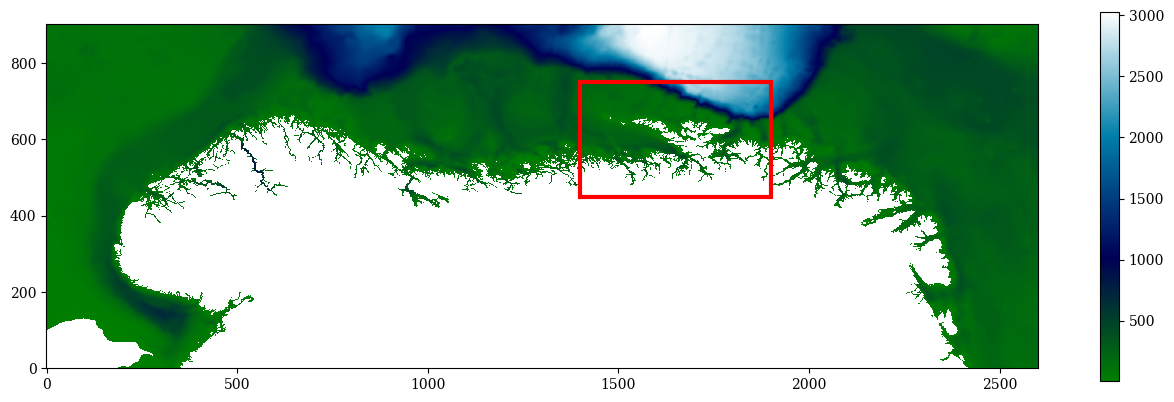

In [10]:
x0 = 900
x1 = 1400
y0 = 600
y1 = 875

x0 = 1400
x1 = int(x0 + 500)
y0 = 450
y1 = int(y0 + 300)

#x0 = 1650
#x1 = int(x0 + 100)
#y0 = 450
#y1 = int(y0 + 200)

land_value = H_full.min()

fig = plt.figure(figsize=(16,12))
land = np.ma.masked_where(H_full == land_value, H_full)
plt.imshow(land, interpolation="None", origin='lower', cmap='ocean')
fig.gca().fill([x0, x0, x1, x1], [y0, y1, y1, y0], fill=False, linestyle='-', linewidth=3, color='red')
plt.colorbar(shrink=0.4)

In [11]:
H_full = None

# Get initial conditions

In [12]:



try:
    ncfile = Dataset(source_url)
    #H_i_orig = ncfile.variables['h'][y0-border_size:y1+border_size+1, x0-border_size:x1+border_size+1]
    H_i_orig = ncfile.variables['h'][y0:y1+1, x0:x1+1]
except Exception as e:
    raise e
finally:
    ncfile.close()
    

Read Hm as (302, 502)
Completed in 3 iterations
(300, 500)
(301, 501)


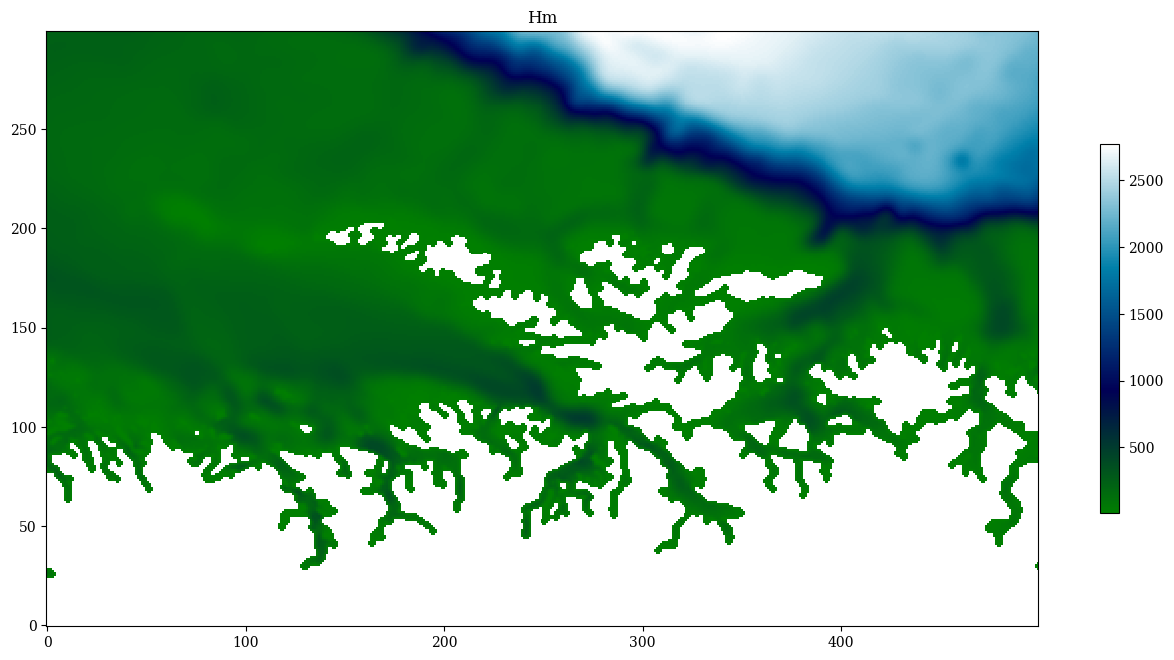

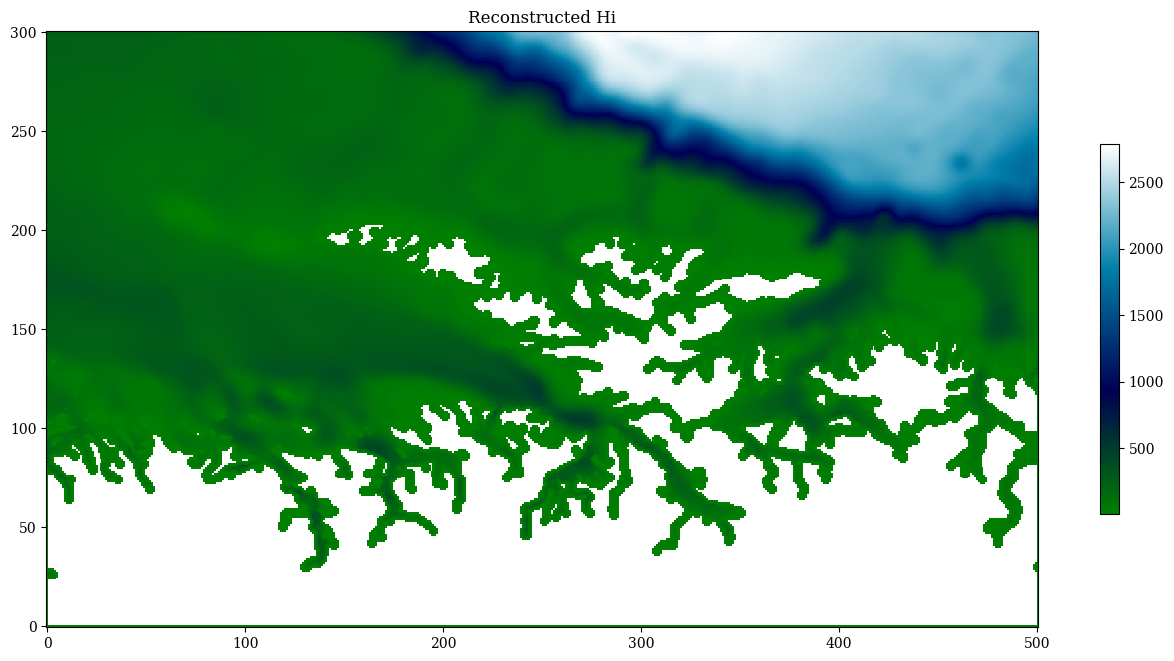

In [13]:


try:
    ncfile = Dataset(source_url)
    H_m = ncfile.variables['h'][y0-1:y1+1, x0-1:x1+1]
    print("Read Hm as " + str(H_m.shape))

except Exception as e:
    raise e
finally:
    ncfile.close()

#Apply land mask
from scipy.ndimage.morphology import binary_erosion
H_m = np.ma.array(H_m, mask = (H_m == land_value))
H_m.mask = binary_erosion(H_m.mask)
H_m.fill_value = land_value

H_i, convergence = OceanographicUtilities.midpointsToIntersections(H_m, 100)
H_m = OceanographicUtilities.intersectionsToMidpoints(H_i)

print("Completed in " + str(len(convergence)) + " iterations")

fig = plt.figure(figsize=(16,8))
plt.imshow(H_m, interpolation="None", origin='lower', cmap='ocean')
plt.colorbar(shrink=0.6)
plt.title("Hm")

fig = plt.figure(figsize=(16,8))
plt.imshow(H_i, interpolation="None", origin='lower', cmap='ocean')
plt.colorbar(shrink=0.6)
plt.title("Reconstructed Hi")


print(H_m.shape)
print(H_i.shape)

[0.92100006, 0.0]
[442.22709902898464, -196.46426490187238]
[238.54638278406827, -196.1060504233866]


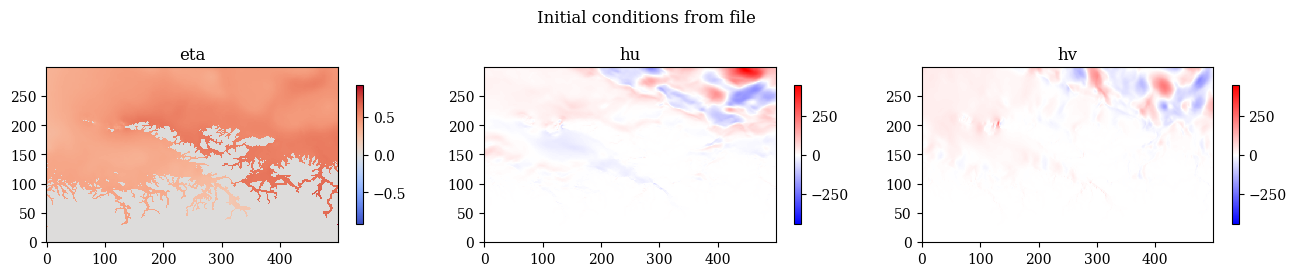

In [14]:
try:
    ncfile = Dataset(source_url)
    eta0 = ncfile.variables['zeta'][0, y0:y1, x0:x1]
    u0 = ncfile.variables['ubar'][0, y0:y1, x0:x1]
    v0 = ncfile.variables['vbar'][0, y0:y1, x0:x1]
except Exception as e:
    raise e
finally:
    ncfile.close()

eta0 = eta0.filled(0)
u0 = u0.filled(0)
v0 = v0.filled(0)

hu0 = (H_m+eta0)*u0
hv0 = (H_m+eta0)*v0

u0 = None
v0 = None

etamax = np.max(np.abs(eta0))
uvmax = max(np.max(np.abs(hu0)), np.max(np.abs(hv0)))
    
plt.figure(figsize=(16, 3))
plt.suptitle("Initial conditions from file")

plt.subplot(1,3,1)
plt.title("eta")
plt.imshow(eta0, interpolation="None", origin='lower', cmap='coolwarm', vmin=-etamax, vmax=etamax)
plt.colorbar(shrink=0.6)

plt.subplot(1,3,2)
plt.title("hu")
plt.imshow(hu0, interpolation="None", origin='lower', cmap='bwr', vmin=-uvmax, vmax=uvmax)
plt.colorbar(shrink=0.6)

plt.subplot(1,3,3)
plt.title("hv")
plt.imshow(hv0, interpolation="None", origin='lower', cmap='bwr', vmin=-uvmax, vmax=uvmax)
plt.colorbar(shrink=0.6)

for var in [eta0, hu0, hv0]:
    print([np.max(var), np.min(var)])

# Get timesteps

In [16]:
timesteps = list(range(0,24))
#timesteps = list(range(0,2))
timestep = list(range(0, 4))

try:
    ncfile = Dataset(norkyst800_url)
    time_var = ncfile.variables['time']
    print(time_var.shape)
    time = time_var[timesteps]
except Exception as e:
    raise e
finally:
    ncfile.close()

print(time)    
time = time - time[0]
print(time)
print([time[0]] + [time[-1]])

(24,)
[1.5632352e+09 1.5632388e+09 1.5632424e+09 1.5632460e+09 1.5632496e+09
 1.5632532e+09 1.5632568e+09 1.5632604e+09 1.5632640e+09 1.5632676e+09
 1.5632712e+09 1.5632748e+09 1.5632784e+09 1.5632820e+09 1.5632856e+09
 1.5632892e+09 1.5632928e+09 1.5632964e+09 1.5633000e+09 1.5633036e+09
 1.5633072e+09 1.5633108e+09 1.5633144e+09 1.5633180e+09]
[    0.  3600.  7200. 10800. 14400. 18000. 21600. 25200. 28800. 32400.
 36000. 39600. 43200. 46800. 50400. 54000. 57600. 61200. 64800. 68400.
 72000. 75600. 79200. 82800.]
[0.0, 82800.0]


# Get boundary conditions

In [15]:
try:
    ncfile = Dataset(norkyst800_url)
    
    H = ncfile.variables['h'][y0-1:y1+1, x0-1:x1+1]
    
    nt = len(time)
    
    bc_eta = {}
    bc_eta['north'] = np.empty((nt, x1-x0), dtype=np.float32)
    bc_eta['south'] = np.empty((nt, x1-x0), dtype=np.float32)
    bc_eta['east'] = np.empty((nt, y1-y0), dtype=np.float32)
    bc_eta['west'] = np.empty((nt, y1-y0), dtype=np.float32)
    
    bc_hu = {}
    bc_hu['north'] = np.empty((nt, x1-x0), dtype=np.float32)
    bc_hu['south'] = np.empty((nt, x1-x0), dtype=np.float32)
    bc_hu['east'] = np.empty((nt, y1-y0), dtype=np.float32)
    bc_hu['west'] = np.empty((nt, y1-y0), dtype=np.float32)
    
    bc_hv = {}
    bc_hv['north'] = np.empty((nt, x1-x0), dtype=np.float32)
    bc_hv['south'] = np.empty((nt, x1-x0), dtype=np.float32)
    bc_hv['east'] = np.empty((nt, y1-y0), dtype=np.float32)
    bc_hv['west'] = np.empty((nt, y1-y0), dtype=np.float32)
    
    progress = Common.ProgressPrinter()
    
    for timestep in range(len(timesteps)):        
        zeta = ncfile.variables['zeta'][timestep, y0-1:y1+1, x0-1:x1+1]
        zeta = zeta.filled(0)
        bc_eta['north'][timestep] = zeta[-1, 1:-1]
        bc_eta['south'][timestep] = zeta[0, 1:-1]
        bc_eta['east'][timestep] = zeta[1:-1, -1]
        bc_eta['west'][timestep] = zeta[ 1:-1, 0]

        h = H + zeta
        
        hu = ncfile.variables['ubar'][timestep, y0-1:y1+1, x0-1:x1+1]
        hu = hu.filled(0) #zero on land
        hu = h*hu
        
        bc_hu['north'][timestep] = hu[-1, 1:-1]
        bc_hu['south'][timestep] = hu[0, 1:-1]
        bc_hu['east'][timestep] = hu[1:-1, -1]
        bc_hu['west'][timestep] = hu[1:-1, 0]

        hv = ncfile.variables['vbar'][timestep, y0-1:y1+1, x0-1:x1+1]
        hv = hv.filled(0) #zero on land
        hv = h*hv
        
        bc_hv['north'][timestep] = hv[-1, 1:-1]
        bc_hv['south'][timestep] = hv[0, 1:-1]
        bc_hv['east'][timestep] = hv[1:-1, -1]
        bc_hv['west'][timestep] = hv[1:-1, 0]
        
        clear_output(wait = True)
        print(progress.getPrintString(timestep / (len(timesteps)-1)))
except Exception as e:
    raise e
finally:
    ncfile.close()

print("Done")

0% [##############################] 100%. Total: 7s, elapsed: 7s, remaining: 0s
Done


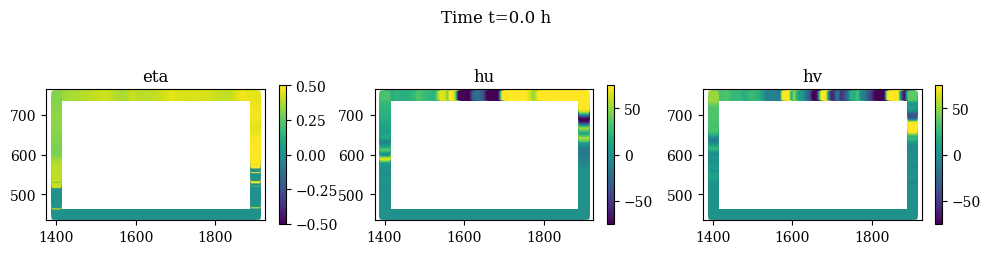

In [16]:
def bcAnimation(create_movie=True, **kwargs):
    nx = x1-x0
    ny = y1-y0
    x_north = np.linspace(x0, x1, nx)
    y_north = np.linspace(y1, y1, nx)

    x_south = np.linspace(x0, x1, nx)
    y_south = np.linspace(y0, y0, nx)

    x_east = np.linspace(x1, x1, ny)
    y_east = np.linspace(y0, y1, ny)

    x_west = np.linspace(x0, x0, ny)
    y_west = np.linspace(y0, y1, ny)
    
    fig = plt.figure(figsize=(12,3))
    
    sc = [None]*12
    ax = [None]*3
    
    plt.suptitle("Time t=" + str(time[0]/3600) + " h")
    ax[0] = plt.subplot(1,3,1)
    plt.title("eta")
    sc[0] = plt.scatter(x_north, y_north, c=bc_eta['north'][0,:], marker='s', vmax=0.5, vmin=-0.5)
    sc[1] = plt.scatter(x_south, y_south, c=bc_eta['south'][0,:], marker='s', vmax=0.5, vmin=-0.5)
    sc[2] = plt.scatter(x_east, y_east, c=bc_eta['east'][0,:], marker='s', vmax=0.5, vmin=-0.5)
    sc[3] = plt.scatter(x_west, y_west, c=bc_eta['west'][0,:], marker='s', vmax=0.5, vmin=-0.5)
    plt.axis('image')
    plt.colorbar(shrink=0.6)
    
    ax[1] = plt.subplot(1,3,2)
    plt.title("hu")
    sc[4] = plt.scatter(x_north, y_north, c=bc_hu['north'][0,:], marker='s', vmax=75, vmin=-75)
    sc[5] = plt.scatter(x_south, y_south, c=bc_hu['south'][0,:], marker='s', vmax=75, vmin=-75)
    sc[6] = plt.scatter(x_east, y_east, c=bc_hu['east'][0,:], marker='s', vmax=75, vmin=-75)
    sc[7] = plt.scatter(x_west, y_west, c=bc_hu['west'][0,:], marker='s', vmax=75, vmin=-75)
    plt.axis('image')
    plt.colorbar(shrink=0.6)
    
    ax[2] = plt.subplot(1,3,3)
    plt.title("hv")
    sc[8] = plt.scatter(x_north, y_north, c=bc_hv['north'][0,:], marker='s', vmax=75, vmin=-75)
    sc[9] = plt.scatter(x_south, y_south, c=bc_hv['south'][0,:], marker='s', vmax=75, vmin=-75)
    sc[10] = plt.scatter(x_east, y_east, c=bc_hv['east'][0,:], marker='s', vmax=75, vmin=-75)
    sc[11] = plt.scatter(x_west, y_west, c=bc_hv['west'][0,:], marker='s', vmax=75, vmin=-75)
    plt.axis('image')
    plt.colorbar(shrink=0.6)
    
    #Helper function which simulates and plots the solution
    def animate(i):
        fig.suptitle("Time = {:04.0f} h".format(time[i]/3600), fontsize=18)
        
        fig.sca(ax[0])
        sc[0].set_array(bc_eta['north'][i])
        sc[1].set_array(bc_eta['south'][i])
        sc[2].set_array(bc_eta['east'][i])
        sc[3].set_array(bc_eta['west'][i])
        
        fig.sca(ax[1])
        sc[4].set_array(bc_hu['north'][i])
        sc[5].set_array(bc_hu['south'][i])
        sc[6].set_array(bc_hu['east'][i])
        sc[7].set_array(bc_hu['west'][i])
        
        fig.sca(ax[2])
        sc[8].set_array(bc_hv['north'][i])
        sc[9].set_array(bc_hv['south'][i])
        sc[10].set_array(bc_hv['east'][i])
        sc[11].set_array(bc_hv['west'][i])

    #Matplotlib for creating an animation
    if (create_movie):
        anim = animation.FuncAnimation(fig, animate, range(len(time)), interval=250)
        plt.close(fig)
        return anim
    else:
        pass
        
bcAnimation(create_movie=create_movie)

In [17]:
sponge_cells={'north':80, 'south':80, 'west':80, 'east':80}
bc = Common.BoundaryConditions(north=3, south=3, east=3, west=3, spongeCells=sponge_cells)
bc_data = Common.BoundaryConditionsData(time, 
            north=Common.SingleBoundaryConditionData(bc_eta['north'], bc_hu['north'], bc_hv['north']),
            south=Common.SingleBoundaryConditionData(bc_eta['south'], bc_hu['south'], bc_hv['south']),
            east=Common.SingleBoundaryConditionData(bc_eta['east'], bc_hu['east'], bc_hv['east']),
            west=Common.SingleBoundaryConditionData(bc_eta['west'], bc_hu['west'], bc_hv['west']))

# Get wind forcing

In [18]:
try:
    ncfile = Dataset(norkyst800_url)
    u_wind = ncfile.variables['Uwind'][timesteps, y0:y1, x0:x1]
    v_wind = ncfile.variables['Vwind'][timesteps, y0:y1, x0:x1]
except Exception as e:
    raise e
finally:
    ncfile.close()

u_wind = u_wind.filled(0)
v_wind = v_wind.filled(0)
    
print(u_wind.shape)
print(v_wind.shape)

(24, 300, 500)
(24, 300, 500)


Text(0, 0.5, '$C_D$')

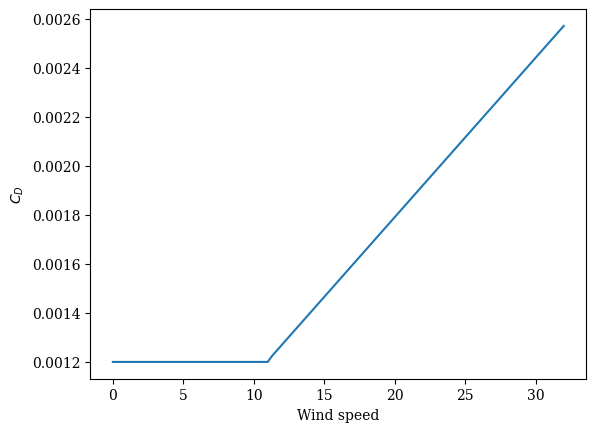

In [19]:
def computeDrag(wind_speed):
    C_drag = np.where(wind_speed < 11, 0.0012, 0.00049 + 0.000065*wind_speed)
    return C_drag

wind_speed = np.linspace(0, 32, 100)
C_drag = computeDrag(wind_speed)

fig = plt.figure()
plt.plot(wind_speed, C_drag, label='Drag coefficient $C_D$')
plt.xlabel("Wind speed")
plt.ylabel("$C_D$")

In [20]:
wind_speed = np.sqrt(np.power(u_wind, 2) + np.power(v_wind, 2))

# C_drag as defined by Engedahl (1995)
#(See "Documentation of simple ocean models for use in ensemble predictions. Part II: Benchmark cases"
#at https://www.met.no/publikasjoner/met-report/met-report-2012 for details.) /
C_drag = computeDrag(wind_speed)

rho_a = 1.225 # Density of air
rho_w = 1025 # Density of water

#Wind stress is then 
# tau_s = rho_a * C_drag * |W|W
wind_stress = C_drag * wind_speed * rho_a / rho_w
wind_stress_u = wind_stress*u_wind
wind_stress_v = wind_stress*v_wind

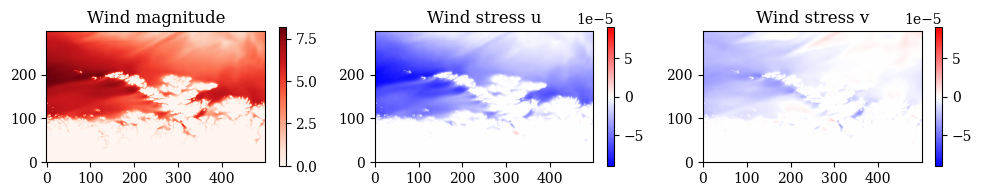

In [21]:
def animateWind(create_movie=True):
    max_speed = np.max(wind_speed)
    max_stress = max(np.max(np.abs(wind_stress_u)), np.max(np.abs(wind_stress_v)))

    fig = plt.figure(figsize=(12,3))
    
    ax = [None]*3
    sc = [None]*3
    
    ax[0] = plt.subplot(1,3,1)
    plt.title("Wind magnitude")
    sc[0] = plt.imshow(wind_speed[0], origin='lower', vmin=0, vmax=max_speed, cmap='Reds')
    plt.colorbar(shrink=0.6)

    ax[1] = plt.subplot(1,3,2)
    plt.title("Wind stress u")
    sc[1] = plt.imshow(wind_stress_u[0], origin='lower', cmap='bwr', vmin=-max_stress, vmax=max_stress)
    plt.colorbar(shrink=0.6)

    ax[2] = plt.subplot(1,3,3)
    plt.title("Wind stress v")
    sc[2] = plt.imshow(wind_stress_v[0], origin='lower', cmap='bwr', vmin=-max_stress, vmax=max_stress)
    plt.colorbar(shrink=0.6)
    
    
    #Helper function which simulates and plots the solution
    def animate(i):
        fig.suptitle("Time = {:04.0f} h".format(time[i]/3600), fontsize=18)
        
        fig.sca(ax[0])
        sc[0].set_data(wind_speed[i])
        
        fig.sca(ax[1])
        sc[1].set_data(wind_stress_u[i])
        
        fig.sca(ax[2])
        sc[2].set_data(wind_stress_v[i])

    #Matplotlib for creating an animation
    if (create_movie):
        anim = animation.FuncAnimation(fig, animate, range(len(time)), interval=250)
        plt.close(fig)
        return anim
    else:
        pass
    
animateWind(create_movie=create_movie)

In [22]:
wind_source = WindStress.WindStress(t=time, stress_u=wind_stress_u, stress_v=wind_stress_v)

# Get domain size

In [23]:
try:
    Dataset(norkyst800_url)
    x = ncfile.variables['X'][x0:x1]
    y = ncfile.variables['Y'][y0:y1]
except Exception as e:
    raise e
finally:
    ncfile.close()

nx = x1 - x0 - 4 # - sponge_cells['west'] - sponge_cells['east']
ny = y1 - y0 - 4 #- sponge_cells['north'] - sponge_cells['south']

dx = np.average(x[1:] - x[:-1])
dy = np.average(y[1:] - y[:-1])

print("Domain size: " + str([nx, ny]))
print("Cell size: " + str([dx, dy]))

Domain size: [496, 296]
Cell size: [800.0, 800.0]


# Get Coriolis parameters

In [24]:
try:
    ncfile = Dataset(source_url)
    angle = ncfile.variables['angle'][y0:y1, x0:x1]
except Exception as e:
    raise e
finally:
    ncfile.close()

(-0.45, 9.45, -0.25, 5.25)

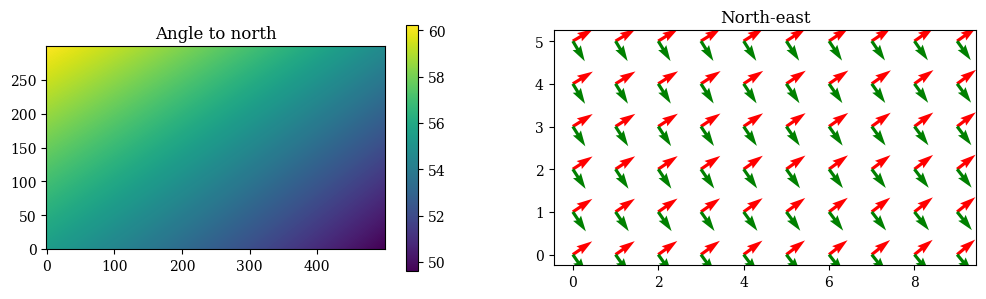

In [25]:
plt.figure(figsize=(12,8))
plt.subplot(1,2,1)
plt.title("Angle to north")
plt.imshow(angle*180/np.pi, origin='lower')
plt.axis('image')
plt.colorbar(shrink=0.4)

plt.subplot(1,2,2)
plt.title("North-east")
plt.quiver(np.sin(angle[::50, ::50]), np.cos(angle[::50, ::50]), color='r')
plt.quiver(np.cos(angle[::50, ::50]), -np.sin(angle[::50, ::50]), color='g')
plt.axis('image')

In [26]:
try:
    ncfile = Dataset(source_url)
    lat = ncfile.variables["lat"][y0:y1, x0:x1]
except Exception as e:
    raise e
finally:
    ncfile.close()

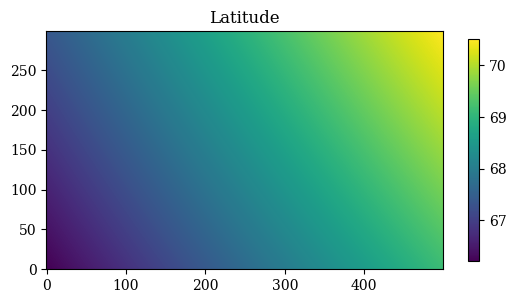

In [27]:
plt.figure()
plt.title("Latitude")
plt.imshow(lat, origin='lower')
plt.colorbar(shrink=0.6)

In [28]:
max_lat = np.max(lat)
min_lat = np.min(lat)
max_cor = OceanographicUtilities.calcCoriolisParams(OceanographicUtilities.degToRad(max_lat))
min_cor = OceanographicUtilities.calcCoriolisParams(OceanographicUtilities.degToRad(min_lat))
print("Max latitude: " + str(max_lat) + " => " + str(max_cor))
print("Min latitude: " + str(min_lat) + " => " + str(min_cor))

Max latitude: 70.50722977667151 => [0.00013748286224375412, 7.638619537909841e-12]
Min latitude: 66.20397967604464 => [0.00013344363545408482, 9.236305632552255e-12]


In [29]:
f, beta = OceanographicUtilities.calcCoriolisParams(OceanographicUtilities.degToRad(lat[0, 0]))
print("F and beta are " + str([f, beta]))

F and beta are [0.00013344363545408482, 9.236305632552255e-12]


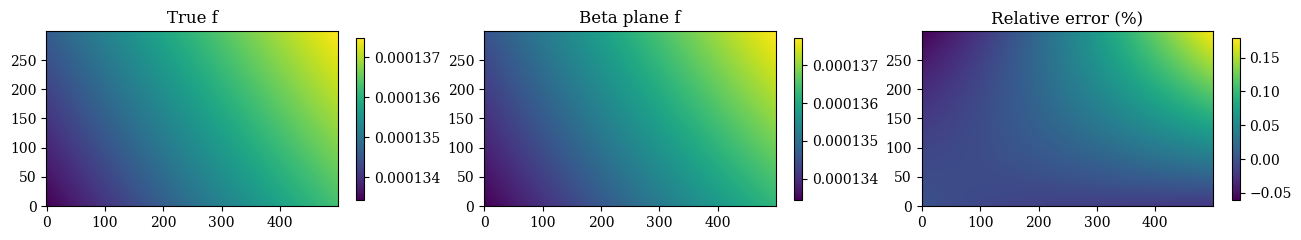

In [30]:
f_truth, _ = OceanographicUtilities.calcCoriolisParams(OceanographicUtilities.degToRad(lat))

#Calculate beta plane approximation
YY, XX = np.mgrid[0:(y1-y0), 0:(x1-x0)]
XX = XX*dx
YY = YY*dy
local_lat = np.sin(angle)*XX + np.cos(angle)*YY
f_beta = f + beta*local_lat

plt.figure(figsize=(16, 3))
plt.subplot(1,3,1)
plt.title("True f")
plt.imshow(f_truth, origin='lower')#, vmin=-0.0002, vmax=0.0002)
plt.colorbar(shrink=0.7)


plt.subplot(1,3,2)
plt.title("Beta plane f")
plt.imshow(f_beta, origin='lower')#, vmin=-0.0002, vmax=0.0002)
plt.colorbar(shrink=0.7)

plt.subplot(1,3,3)
plt.title("Relative error (%)")
plt.imshow(100*(f_beta-f_truth) / f_truth, origin='lower')#, vmin=-0.0001, vmax=0.0)
plt.colorbar(shrink=0.7)



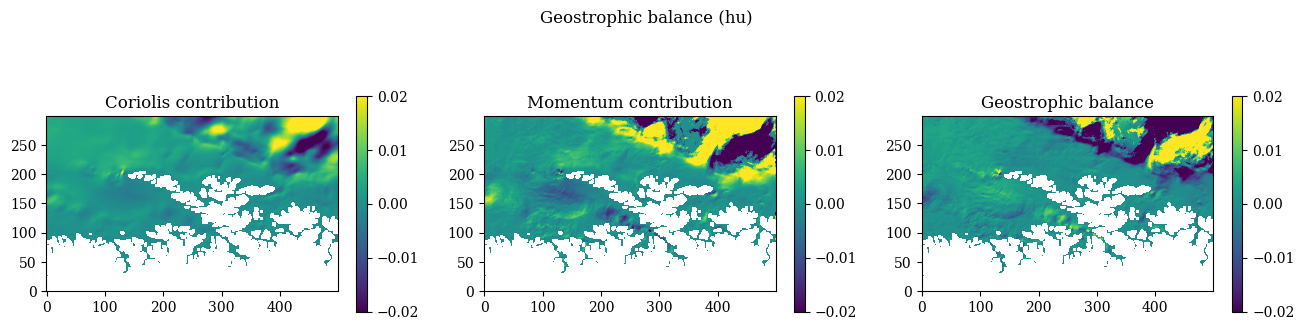

In [31]:
geos, geos_x, geos_y = OceanographicUtilities.calcGeostrophicBalance(
                            eta0, 
                            H_m, 
                            hu0, hv0, 
                            angle, f_beta,
                            dx, dy,
                            use_minmod=True)

plt.figure(figsize=(16,4))
plt.suptitle("Geostrophic balance (hu)")
plt.subplot(1,3,1)
plt.title("Coriolis contribution")
plt.imshow(geos_x[0], origin='lower', vmax=0.02, vmin=-0.02)
plt.colorbar(shrink=0.7)

plt.subplot(1,3,2)
plt.title("Momentum contribution")
plt.imshow(geos_x[1], origin='lower', vmax=0.02, vmin=-0.02)
plt.colorbar(shrink=0.7)

plt.subplot(1,3,3)
plt.title("Geostrophic balance")
plt.imshow(geos[0], origin='lower', vmax=0.02, vmin=-0.02)
plt.colorbar(shrink=0.7)

# Helpers for plotting and running simulation

In [32]:
def ncSimulation(sim, filename, timesteps, interior_domain_only, num_substeps = 3):
    """
    Run simulation given in sim and write the results to netCDF file
    TODO: Replace with the built-in netCDF writer available in the sim.
    """
    if (os.path.isfile(filename)):
        print("File " + filename + " already exists, skipping simulation.")
        return
    
    try:
        ncfile = Dataset(filename, 'w')

        var = {}
        var['eta'], var['hu'], var['hv'] = sim.download(interior_domain_only=interior_domain_only)
        _, var['Hm'] = sim.downloadBathymetry(interior_domain_only=interior_domain_only)

        ny, nx = var['eta'].shape

        # Create dimensions
        ncfile.createDimension('time', None) # unlimited
        ncfile.createDimension('x', nx)
        ncfile.createDimension('y', ny)

        ncvar = {}

        # Create variables for dimensions
        ncvar['time'] = ncfile.createVariable('time', 'f8', ('time',))
        ncvar['x'] = ncfile.createVariable('x', 'f4', ('x',))
        ncvar['y'] = ncfile.createVariable('y', 'f4', ('y',))

        # Fill dimension variables
        ncvar['x'][:] = np.linspace(0, nx*sim.dx, nx)
        ncvar['y'][:] = np.linspace(0, ny*sim.dy, ny)

        # Create static variables
        ncvar['Hm'] = ncfile.createVariable('Hm', 'f8', ('y', 'x',), zlib=True)
        ncvar['Hm'][:,:] = var['Hm'][:,:]

        # Create time varying data variables
        for varname in ['eta', 'hu', 'hv']:
            ncvar[varname] = ncfile.createVariable(varname, 'f8', ('time', 'y', 'x',), zlib=True)
        ncvar['num_iterations'] = ncfile.createVariable('num_iterations', 'i4', ('time',))

        #Simulate n timesteps
        timestep_sizes = timesteps[1:] - timesteps[:-1]
        timestep_sizes = np.insert(timestep_sizes, 0, 0)

        with Common.ProgressPrinter(5) as progress:
            for i, timestep_size in enumerate(timestep_sizes):
                #Don't simulate if first step (store initial conditions also)
                if (timestep_size > 0):
                    substep_size = timestep_size / num_substeps
                    for j in range(num_substeps):
                        sim.updateDt()
                        sim.step(substep_size)

                var['eta'], var['hu'], var['hv'] = sim.download(interior_domain_only=False)
                ncvar['time'][i] = sim.t
                ncvar['num_iterations'][i] = sim.num_iterations

                abort=False
                for varname in ['eta', 'hu', 'hv']:
                    ncvar[varname][i,:,:] = var[varname][:,:] #np.ma.masked_invalid(var[varname][:,:])
                    if (np.any(np.isnan(var[varname]))):
                        print("Variable " + varname + " contains NaN values!")
                        abort=True

                if (abort):
                    print("Aborting at t=" + str(sim.t))
                    ncfile.sync()
                    break

                clear_output(wait = True)
                print(progress.getPrintString(i/(len(timestep_sizes)-1)))

    except Exception as e:
        print("Something went wrong:" + str(e))
        raise e
    finally:
        ncfile.close()

In [33]:
def ncAnimation(filename, movie_frames=None, create_movie=True, fig=None, **kwargs):
    """
    Make animation of the netcdf file. 
    If movie_frames is not None, the plotted states are interpolated between the available timesteps
    """
    #Create figure and plot initial conditions
    if fig is None:
        fig = plt.figure(figsize=(14, 4))

    try:
        ncfile = Dataset(filename)
        x = ncfile.variables['x'][:]
        y = ncfile.variables['y'][:]
        t = ncfile.variables['time'][:]

        H_m = ncfile.variables['Hm'][:,:]
        eta = ncfile.variables['eta'][:,:,:]
        hu = ncfile.variables['hu'][:,:,:]
        hv = ncfile.variables['hv'][:,:,:]
    except Exception as e:
        raise e
    finally:
        ncfile.close()


    if movie_frames is None:
        movie_frames = len(t)

    dx = x[1] - x[0]
    dy = y[1] - y[0]
    
    progress = Common.ProgressPrinter(5)

    if (create_movie):
        ax, sp = plotSolution(fig, 
                              eta[0],
                              hu[0],
                              hv[0],
                              H_m+eta[0],
                              dx, dy, 
                              t[0], filename,
                              **kwargs)
    else:
        ax, sp = plotSolution(fig, 
                              eta[-1],
                              hu[-1],
                              hv[-1],
                              H_m+eta[-1],
                              dx, dy, 
                              t[-1], filename,
                              **kwargs)
        return

    #Helper function which simulates and plots the solution    
    def animate(i):
        t_now = t[0] + (i / (movie_frames-1)) * (t[-1] - t[0]) 

        k = np.searchsorted(t, t_now)
        if (k >= eta.shape[0]):
            k = eta.shape[0] - 1
        j = max(0, k-1)
        if (j == k):
            k += 1
        s = (t_now - t[j]) / (t[k] - t[j])

        plotSolution(fig, 
                     (1-s)*eta[j] + s*eta[k], 
                     (1-s)*hu[j]  + s*hu[k], 
                     (1-s)*hv[j]  + s*hv[k], 
                     H_m+(1-s)*eta[j] + s*eta[k], 
                     dx, dy, 
                     t_now, filename, 
                     **kwargs, ax=ax, sp=sp)

        clear_output(wait = True)
        print(progress.getPrintString(i / (movie_frames-1)))

    #Matplotlib for creating an animation
    anim = animation.FuncAnimation(fig, animate, range(movie_frames), interval=100)
    plt.close(fig)
    
    return anim

# Plot reference solution

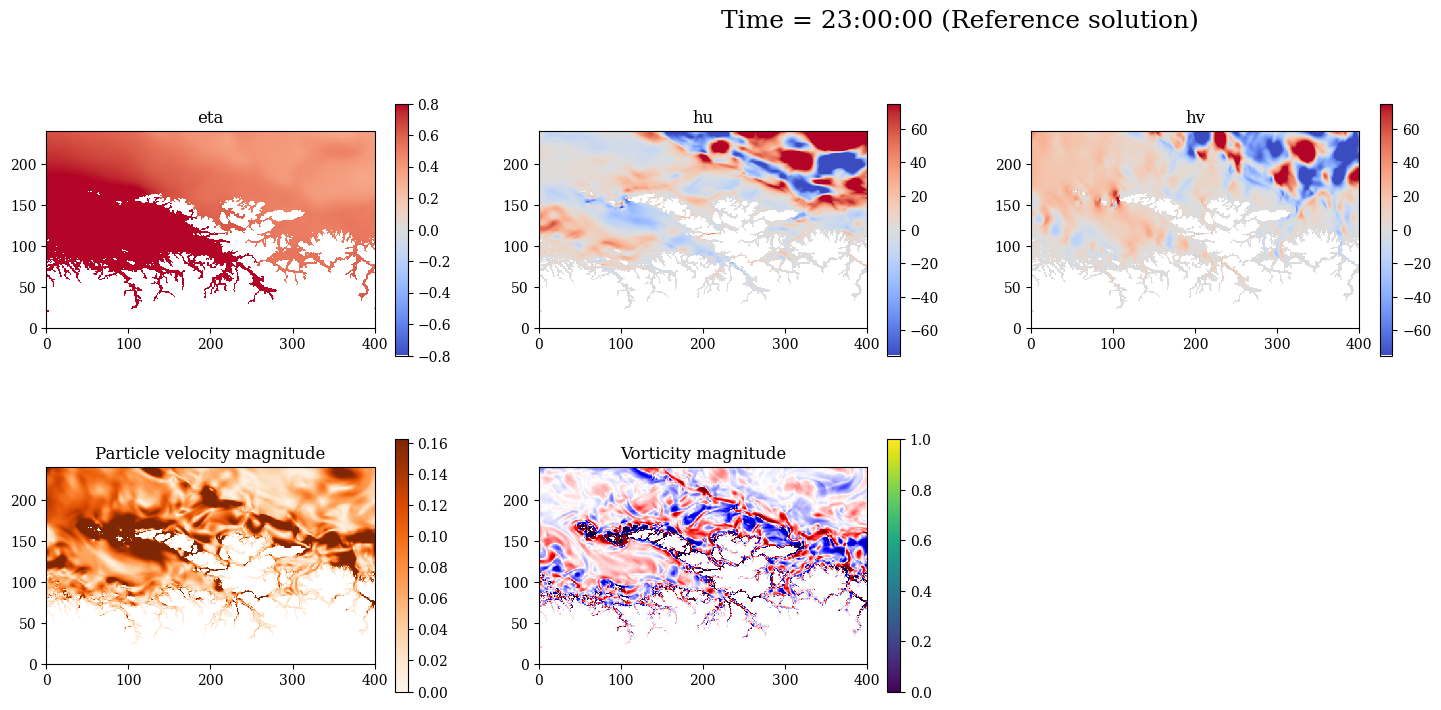

In [34]:
def refAnimation(t, fig=None, movie_frames=None, create_movie=True, **kwargs):
    """
    Norkyst-specific animation function
    """
    #Create figure and plot initial conditions
    if fig is None:
        fig = plt.figure(figsize=(12, 4))  
    
    tsteps = timesteps
    if (not create_movie):
        tsteps = [tsteps[0]] + [tsteps[-1]]
        
    if movie_frames is None:
        movie_frames = len(tsteps)
        
    try:
        ncfile = Dataset(source_url)
        H_m = ncfile.variables['h'][y0:y1, x0:x1]
        eta = ncfile.variables['zeta'][tsteps, y0:y1, x0:x1]
        hu = ncfile.variables['ubar'][tsteps, y0:y1, x0:x1]
        hv = ncfile.variables['vbar'][tsteps, y0:y1, x0:x1]
        
        for timestep in range(len(tsteps)):
            hu[timestep] = hu[timestep] * (H_m + eta[timestep])
            hv[timestep] = hv[timestep] * (H_m + eta[timestep])
    except Exception as e:
        raise e
    finally:
        ncfile.close()

    
    progress = Common.ProgressPrinter(5)
    if (create_movie):
        ax, sp = plotSolution(fig, 
                              eta[0],
                              hu[0],
                              hv[0],
                              H_m+eta[0],
                              dx, dy, 
                              t[0], "Reference solution",
                              **kwargs)
    else:
        ax, sp = plotSolution(fig, 
                              eta[-1],
                              hu[-1],
                              hv[-1],
                              H_m+eta[-1],
                              dx, dy,
                              t[-1], "Reference solution",
                              **kwargs)
        return
    
    progress = Common.ProgressPrinter(5)
    
    #Helper function which simulates and plots the solution    
    def animate(i):
        t_now = t[0] + (i / (movie_frames-1)) * (t[-1] - t[0]) 
        
        k = np.searchsorted(time, t_now)
        if (k >= eta.shape[0]):
            k = eta.shape[0] - 1
        j = max(0, k-1)
        if (j == k):
            k += 1
        s = (t_now - t[j]) / (t[k] - t[j])
        
        plotSolution(fig, 
                     (1-s)*eta[j] + s*eta[k], 
                     (1-s)*hu[j]  + s*hu[k], 
                     (1-s)*hv[j]  + s*hv[k], 
                     H_m+(1-s)*eta[j] + s*eta[k], 
                     dx, dy, 
                     t_now, "Reference solution",
                     **kwargs, ax=ax, sp=sp)
        
        clear_output(wait = True)
        print(progress.getPrintString(i / (movie_frames-1)))

    #Matplotlib for creating an animation
    anim = animation.FuncAnimation(fig, animate, range(movie_frames), interval=100)
    plt.close(fig)
    return anim

fig = plt.figure(figsize=(18, 8))  
refAnimation(time, 
             fig=fig,
             movie_frames=movie_frames, 
             create_movie=create_movie,
             h_max=0.8, h_min=-0.8, 
             uv_max=75, uv_min=-75, 
             add_extra=True)

# Run original resolution simulation

In [35]:
print(eta0.shape, hu0.shape, H_i.shape)
print(nx, ny)

(300, 500) (300, 500) (301, 501)
496 296


In [36]:
importlib.reload(CDKLM16)

# Set initial conditions 
sim_args = {
    "gpu_ctx": gpu_ctx,
    "nx": nx, "ny": ny,
    "dx": dx, "dy": dy,
    "dt": 0.0,
    "g": 9.81,
    "f": f,
    #"coriolis_beta": beta,
    #"r": 2.4e-3,
    #"r": 1.6e-4,
    "r": 0.0,
    "rk_order": 2
}

data_args = {"H": H_i, 
             "eta0": eta0, 
             "hu0": hu0, 
             "hv0": hv0,
             "angle": angle,
             "boundary_conditions": bc,
             "boundary_conditions_data": bc_data,
             "wind": wind_source
            }
sim = CDKLM16.CDKLM16(**sim_args, **data_args)

ncSimulation(sim=sim, 
             filename="original.nc",
             timesteps=time,
             interior_domain_only=False)

Subsampling angle texture by factor 10
This will give inaccurate angle along the border!


File original.nc already exists, skipping simulation.


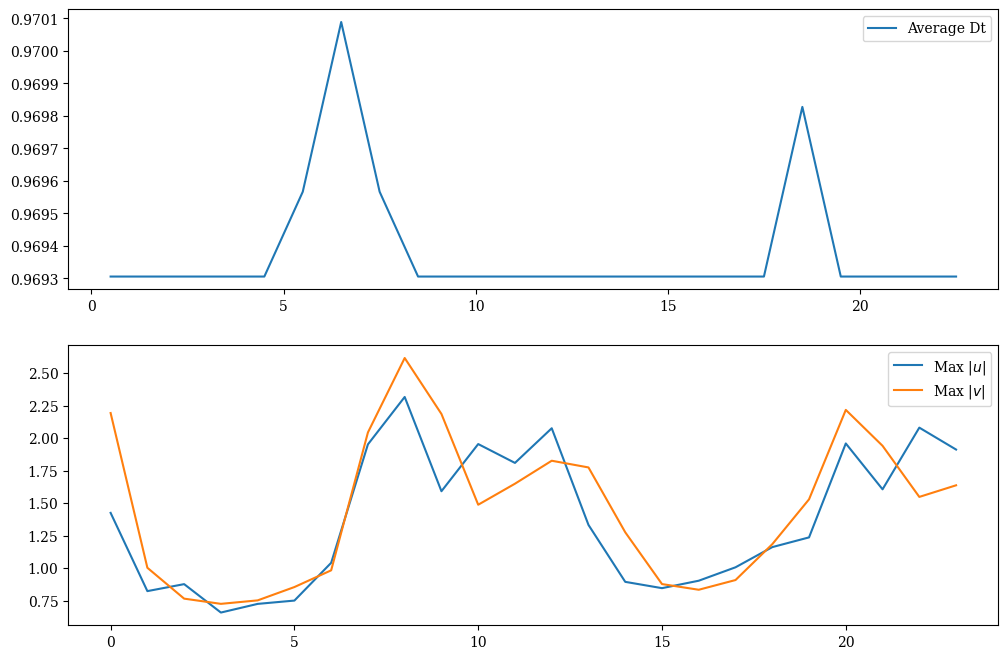

In [37]:
def plotStatistics(filename): 
    try:
        ncfile = Dataset(filename)
        t = ncfile.variables['time'][:]
        num_iterations = ncfile.variables['num_iterations'][:]

        num_timesteps = len(t)
        max_abs_u = np.zeros(num_timesteps)
        max_abs_v = np.zeros(num_timesteps)
        
        H_m = ncfile.variables['Hm'][:,:]
        
        for i in range(num_timesteps):
            h = H_m + ncfile.variables['eta'][i,:,:]
            
            u = ncfile.variables['hu'][i,:,:] / h
            v = ncfile.variables['hv'][i,:,:] / h
            
            max_abs_u[i] = np.max(np.abs(u))
            max_abs_v[i] = np.max(np.abs(v))
            
        
    except Exception as e:
        print("Something went wrong:" + str(e))
        raise e
    finally:
        ncfile.close()

    plt.title("Statistics")
    plt.subplot(2,1,1)
    plt.plot(0.5*(t[1:] + t[:-1])/3600, np.diff(t)/np.diff(num_iterations), label="Average Dt")
    plt.legend()
    plt.subplot(2,1,2)
    plt.plot(t/3600, max_abs_u, label="Max $|u|$")
    plt.plot(t/3600, max_abs_v, label="Max $|v|$")
    plt.legend()

plt.figure(figsize=(12,8))
plotStatistics("original.nc")

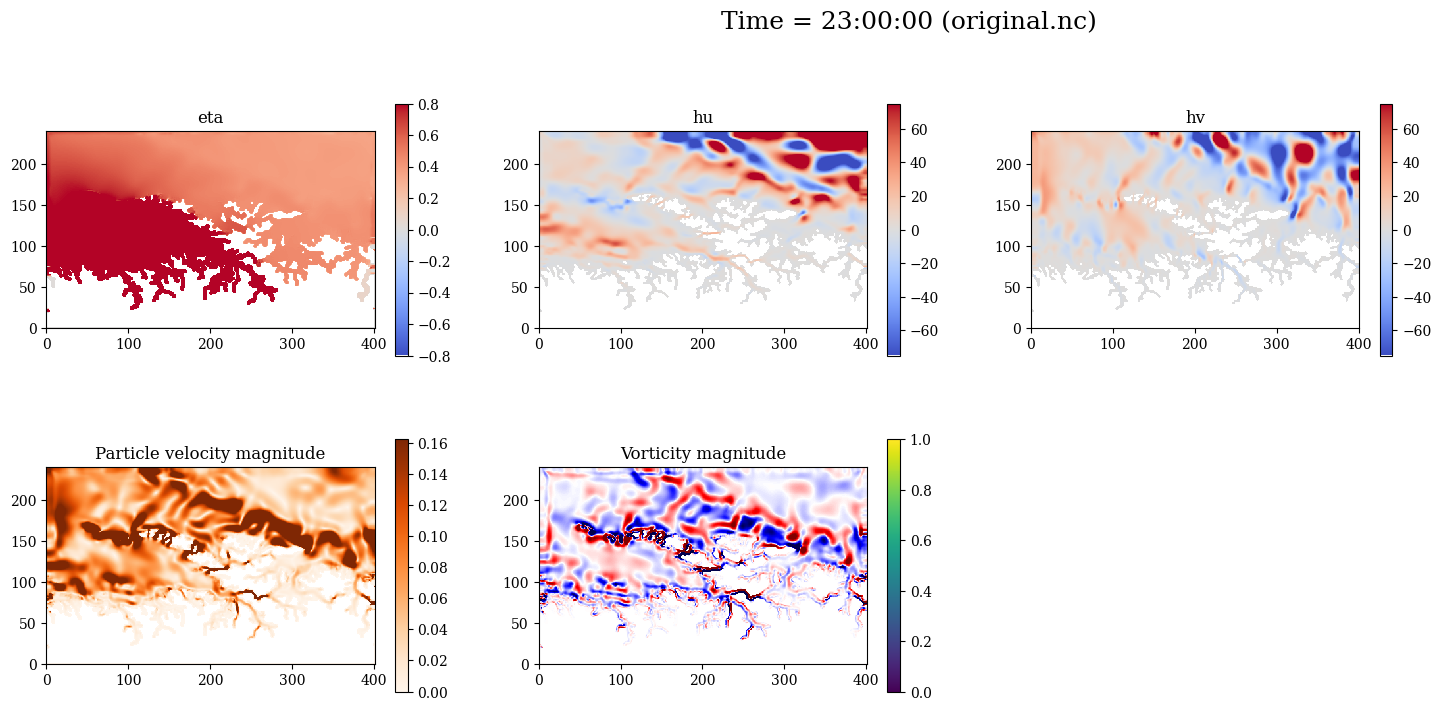

In [38]:
ncAnimation("original.nc", 
             movie_frames=movie_frames, 
             create_movie=create_movie,
             fig=plt.figure(figsize=(18,8)),
             h_max=0.8, h_min=-0.8, 
             uv_max=75, uv_min=-75, 
             add_extra=True)

# Simulate low-resolution

In [39]:
importlib.reload(OceanographicUtilities)

#Set scaling factor
scale = 0.5

nx_new = int((x1 - x0)*scale) - 4
ny_new = int((y1 - y0)*scale) - 4

# Set initial conditions 
sim_args = {
    "gpu_ctx": gpu_ctx,
    "nx": nx_new, "ny": ny_new,
    "dx": dx/scale, "dy": dy/scale,
    "dt": 0.0,
    "g": 9.81,
    "f": f,
    #"coriolis_beta": beta,
    #"r": 2.4e-3,
    #"r": 1.6e-4,
    "r": 0.0,
    "rk_order": 2
}

data_args = {"H": OceanographicUtilities.rescaleIntersections(H_i, int((H_i.shape[1]-1)*scale)+1, int((H_i.shape[0]-1)*scale)+1)[2],
             "eta0": OceanographicUtilities.rescaleMidpoints(eta0, eta0.shape[1]*scale, eta0.shape[0]*scale)[2], 
             "hu0": OceanographicUtilities.rescaleMidpoints(hu0, hu0.shape[1]*scale, hu0.shape[0]*scale)[2], 
             "hv0": OceanographicUtilities.rescaleMidpoints(hv0, hv0.shape[1]*scale, hv0.shape[0]*scale)[2],
             "angle": angle,
             "boundary_conditions": bc,
             "boundary_conditions_data": bc_data,
             "wind": wind_source
            }
sim = CDKLM16.CDKLM16(**sim_args, **data_args)
ncSimulation(sim=sim, 
             filename="lowres.nc",
             timesteps=time,
             interior_domain_only=False)

Subsampling angle texture by factor 10
This will give inaccurate angle along the border!


File lowres.nc already exists, skipping simulation.


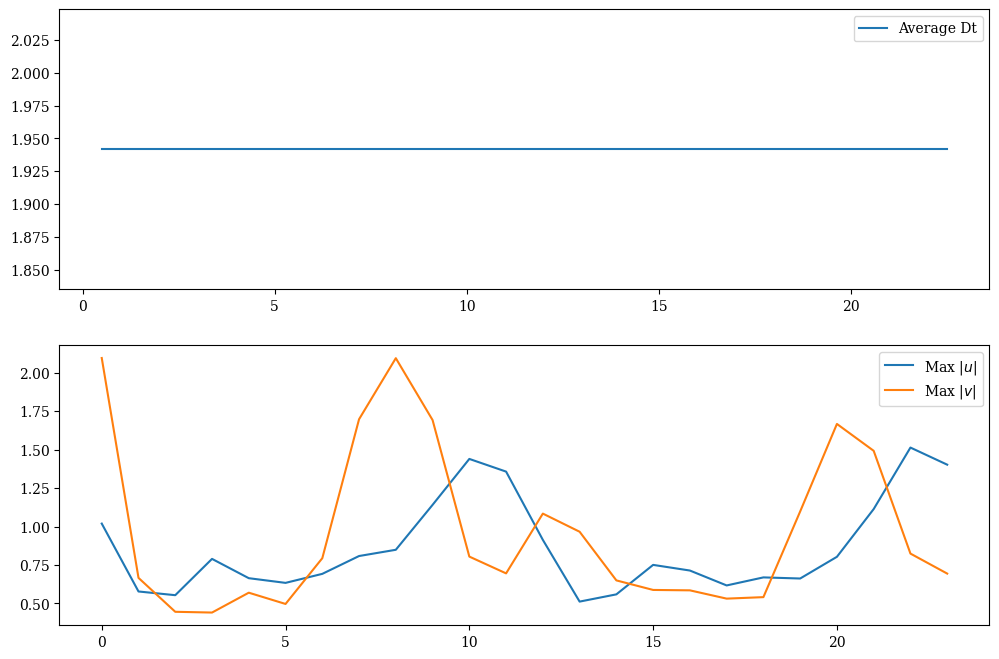

In [40]:
plt.figure(figsize=(12,8))
plotStatistics("lowres.nc")

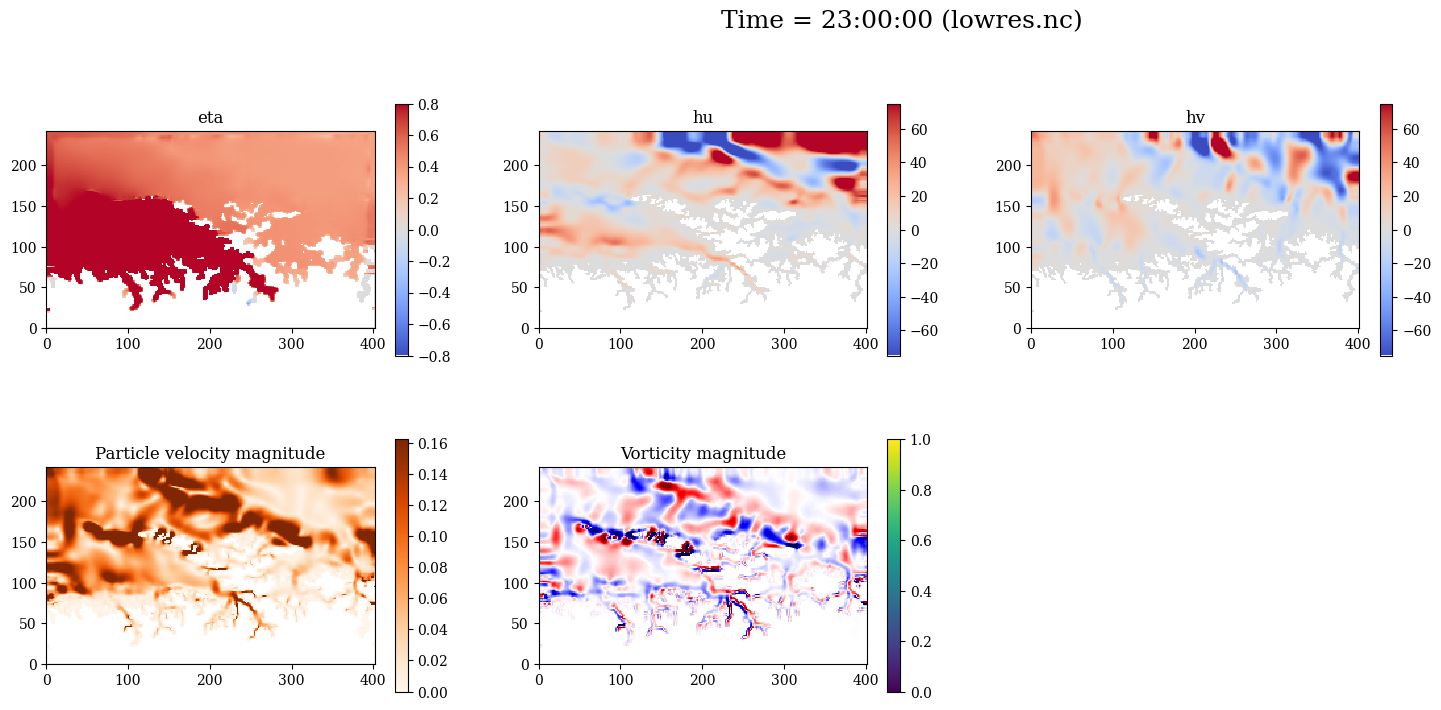

In [41]:
ncAnimation("lowres.nc", 
             movie_frames=movie_frames, 
             create_movie=create_movie,
             fig=plt.figure(figsize=(18,8)),
             h_max=0.8, h_min=-0.8, 
             uv_max=75, uv_min=-75, 
             add_extra=True)

# Simulate high-resolution

In [42]:
#Set scaling factor
scale = 2

nx_new = (x1 - x0)*scale - 4
ny_new = (y1 - y0)*scale - 4

# Set initial conditions 
sim_args = {
    "gpu_ctx": gpu_ctx,
    "nx": nx_new, "ny": ny_new,
    "dx": dx/scale, "dy": dy/scale,
    "dt": 0.0,
    "g": 9.81,
    "f": f,
    #"coriolis_beta": beta,
    #"r": 2.4e-3,
    #"r": 1.6e-4,
    "r": 0.0,
    "rk_order": 2
}

data_args = {"H": OceanographicUtilities.rescaleIntersections(H_i, (H_i.shape[1]-1)*scale+1, (H_i.shape[0]-1)*scale+1)[2],
             "eta0": OceanographicUtilities.rescaleMidpoints(eta0, eta0.shape[1]*scale, eta0.shape[0]*scale)[2], 
             "hu0": OceanographicUtilities.rescaleMidpoints(hu0, hu0.shape[1]*scale, hu0.shape[0]*scale)[2], 
             "hv0": OceanographicUtilities.rescaleMidpoints(hv0, hv0.shape[1]*scale, hv0.shape[0]*scale)[2],
             "angle": angle,
             "boundary_conditions": bc,
             "boundary_conditions_data": bc_data,
             "wind": wind_source
            }
sim = CDKLM16.CDKLM16(**sim_args, **data_args)
ncSimulation(sim=sim, 
             filename="highres.nc",
             timesteps=time,
             interior_domain_only=False)

File highres.nc already exists, skipping simulation.


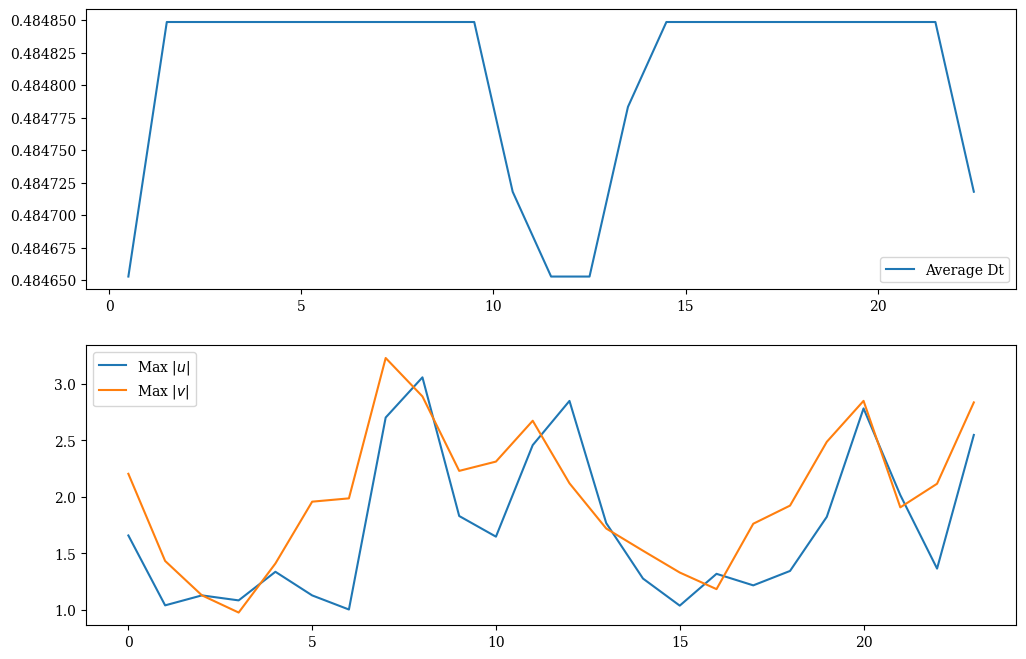

In [43]:
plt.figure(figsize=(12,8))
plotStatistics("highres.nc")

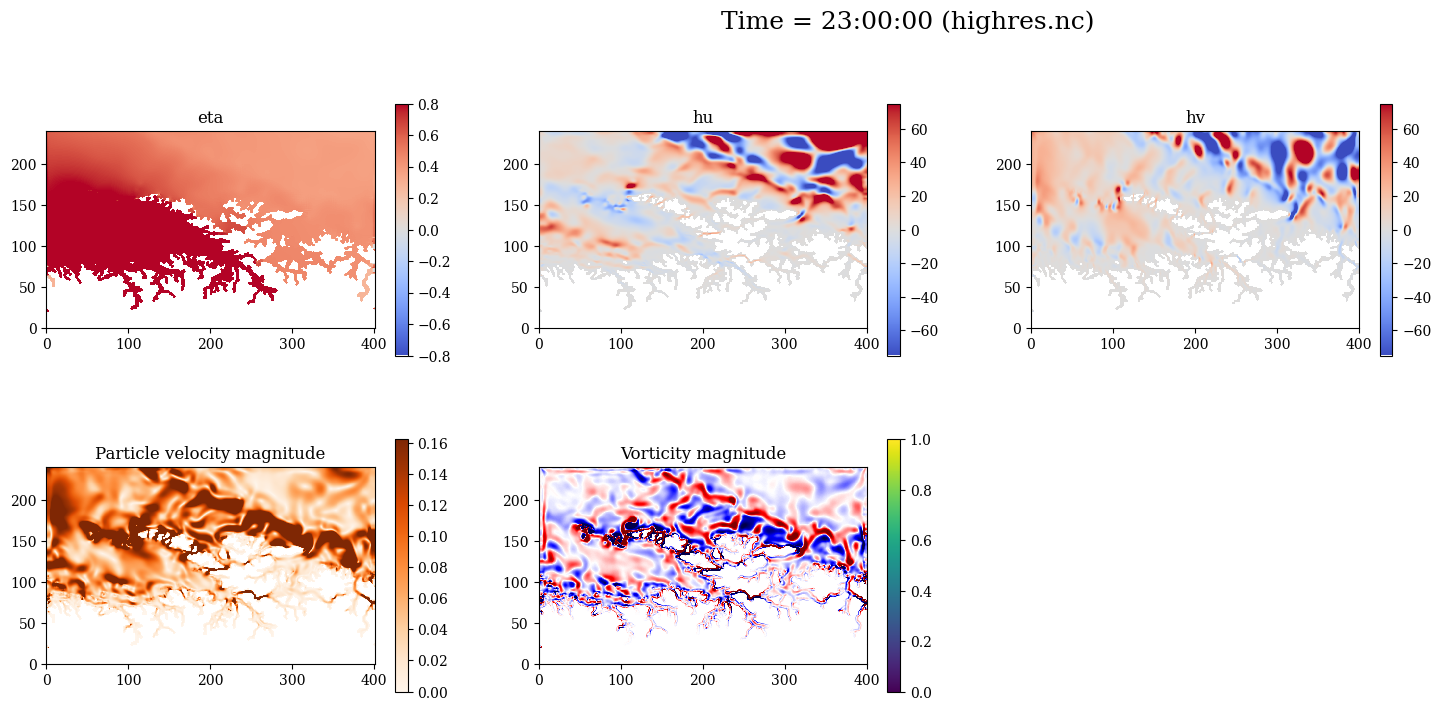

In [44]:
ncAnimation("highres.nc", 
             movie_frames=movie_frames, 
             create_movie=create_movie,
             fig=plt.figure(figsize=(18,8)),
             h_max=0.8, h_min=-0.8, 
             uv_max=75, uv_min=-75, 
             add_extra=True)